In [2]:
import yfinance as yf
import pandas as pd
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import CLA
import pypfopt
import matplotlib.pyplot as plt
import datetime
from datetime import date
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy.stats import norm
from sklearn import preprocessing
import functools

#rio = yf.Ticker("RIO")
#bhp=yf.Ticker('BHP')
#hist = rio.history(period="5y")
#print(len(hist))



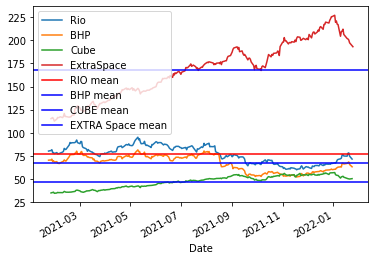

Correlation Open               0.962968
High               0.962953
Low                0.962314
Close              0.963437
Adj Close          0.924651
Volume             0.582368
open_pct_change    0.836487
dtype: float64


In [6]:
rio_df=pd.read_csv('RIO.csv',parse_dates=['Date'],index_col=0)
bhp_df=pd.read_csv('BHP.csv',parse_dates=['Date'],index_col=0)
cube_df=pd.read_csv('CUBE.csv',parse_dates=['Date'],index_col=0)
extra_df=pd.read_csv('EXR.csv',parse_dates=['Date'],index_col=0)
#filter=((rio_df.index>'1/1/2017') & (rio_df.index<='1/20/2022'))
#rio_df=rio_df[filter]
#rio_df['Open'].plot(label='Rio')
#filter=((bhp_df.index>'1/1/2017') & (bhp_df.index<='1/20/2022'))
#bhp_df=bhp_df[filter]
#bhp_df['Open'].plot(label='BHP')
#filter=((cube_df.index>'1/1/2017') & (cube_df.index<='1/20/2022'))
#cube_df=cube_df[filter]
#cube_df['Open'].plot(label='CUBE')
rio_df=rio_df.sort_index().tail(254)
bhp_df=bhp_df.sort_index().tail(254)
cube_df=cube_df.sort_index().tail(254)
extra_df=extra_df.sort_index().tail(254)
#filter=((extra_df.index>'1/1/2017') & (extra_df.index<='1/20/2022'))
#extra_df=extra_df[filter]
#extra_df['Open'].plot(label='EXTRASPACE')

rio_df['Open'].plot(label='Rio')
bhp_df['Open'].plot(label='BHP')
cube_df['Open'].plot(label='Cube')
extra_df['Open'].plot(label='ExtraSpace')

rio_df['open_pct_change']=rio_df['Open'].pct_change()
bhp_df['open_pct_change']=bhp_df['Open'].pct_change()
cube_df['open_pct_change']=cube_df['Open'].pct_change()
extra_df['open_pct_change']=extra_df['Open'].pct_change()

mean = rio_df['Open'].mean()
plt.axhline(y=mean, color='r', linestyle='-',label='RIO mean')

mean = bhp_df['Open'].mean()
plt.axhline(y=mean, color='b', linestyle='-',label='BHP mean')

mean = cube_df['Open'].mean()
plt.axhline(y=mean, color='b', linestyle='-',label='CUBE mean')

mean = extra_df['Open'].mean()
plt.axhline(y=mean, color='b', linestyle='-',label='EXTRA Space mean')

plt.legend()
plt.show()
print("Correlation",rio_df.corrwith(bhp_df,axis=0))

In [7]:
portfolio_returns_rio=rio_df.resample('Q')['Open'].sum().reset_index()
portfolio_returns_bhp=bhp_df.resample('Q')['Open'].sum().reset_index()
portfolio_returns_cube=cube_df.resample('Q')['Open'].sum().reset_index()
portfolio_returns_extra=extra_df.resample('Q')['Open'].sum().reset_index()
#portfolio_returns_rio.plot()
#portfolio_returns_bhp.plot()

Index(['Date', 'Open_x', 'Open_y', 'Open'], dtype='object')
Index(['Date', 'Rio', 'BHP', 'Cube', 'Date', 'Extra'], dtype='object')


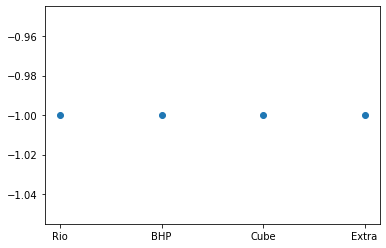

In [12]:
dfs=[portfolio_returns_rio,portfolio_returns_bhp,portfolio_returns_cube]
prices = functools.reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
print(prices.columns)
prices=prices.rename(columns={"Open":"Open_Rio","Open_x":"Open_BHP","Open_y": "Open_Cube"})
#prices=rio_df.merge(bhp_df,cube_df, on="Date",suffixes=['_Rio','_BHP','_CUBE'])
#print(prices)
prices=pd.DataFrame({'Date':prices.index,'Rio':prices['Open_Rio'],'BHP':prices['Open_BHP'],'Cube':prices['Open_Cube']})
prices=pd.concat([prices,portfolio_returns_extra],axis=1)
prices=prices.rename(columns={"Open":"Extra"})
print(prices.columns)

prices.set_index("Date",inplace=True)
#print(prices)

mean_returns=mean_historical_return(prices,frequency=252)

# Plot the annualized average historical return
plt.plot(mean_returns, linestyle = 'None', marker = 'o')
plt.show()

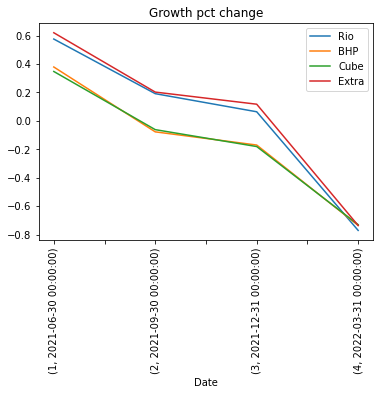

In [13]:
chg=prices.pct_change()
chg.plot()
plt.title('Growth pct change')
plt.xticks(rotation=90)
plt.show()



In [14]:
cs = CovarianceShrinkage(prices)
sample_cov = prices.pct_change().cov() * 252
e_cov = cs.ledoit_wolf()

print("Sample Covariance Matrix\n", sample_cov, "\n")
print("Efficient Covariance Matrix\n", e_cov, "\n")

Sample Covariance Matrix
              Rio        BHP       Cube      Extra
Rio    81.082095  64.555708  62.913000  81.269835
BHP    64.555708  52.783407  51.236878  64.814423
Cube   62.913000  51.236878  49.796430  63.100721
Extra  81.269835  64.814423  63.100721  81.540449 

Efficient Covariance Matrix
              Rio        BHP       Cube      Extra
Rio    56.964322  31.614571  30.810095  39.799903
BHP    31.614571  43.105736  25.092001  31.741270
Cube   30.810095  25.092001  41.642937  30.902026
Extra  39.799903  31.741270  30.902026  57.188790 



In [15]:
ef=pypfopt.efficient_frontier.EfficientFrontier(None, e_cov)
min_vol_weights=ef.min_volatility()
print("Percentage to be held in the portfolio in the period", min_vol_weights)

Percentage to be held in the portfolio in the period OrderedDict([('Rio', 0.0659952272661206), ('BHP', 0.4156713611230353), ('Cube', 0.4586435192374475), ('Extra', 0.0596898923733969)])


Constrained Line Algorithm (CLA) class: generates the entire efficient frontier
1. requires covariance matrix of returns
2. requires proxy for expected future returns: mean historical returns
The expected return is the profit or loss that an investor anticipates on an investment that has known historical rates of return (RoR).


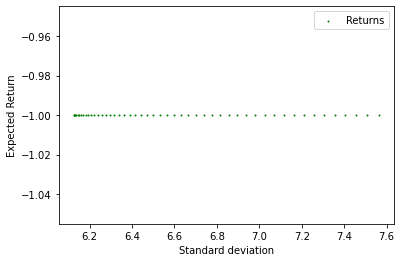

the expected returns is 10%


In [16]:
print("Constrained Line Algorithm (CLA) class: generates the entire efficient frontier")
print("1. requires covariance matrix of returns")
print("2. requires proxy for expected future returns: mean historical returns")
print("The expected return is the profit or loss that an investor anticipates on an investment that has known historical rates of return (RoR).")
    
cla=CLA(mean_returns,e_cov)

(ret, vol, weights) = cla.efficient_frontier()

# Add the frontier to the plot showing the 'before' and 'after' frontiers
plt.scatter(vol, ret, s = 4, c = 'g', marker = '.', label = 'Returns')
plt.xlabel('Standard deviation')
plt.ylabel('Expected Return')
plt.legend()
plt.show()

print("the expected returns is 10%")

In [17]:
rio_returns=rio_df['open_pct_change']
bhp_returns=bhp_df['open_pct_change']
cube_returns=cube_df['open_pct_change']
extra_returns=extra_df['open_pct_change']

print("\nvolatility rio",np.sqrt(252)*rio_returns.std(),
      "\nvolatility bhp",np.sqrt(252)*bhp_returns.std(),
      "\nvolatility cube",np.sqrt(252)*cube_returns.std(),
      "\nvolatility extra",np.sqrt(252)*extra_returns.std())



volatility rio 0.32061982694823465 
volatility bhp 0.3101650470471958 
volatility cube 0.2181622054606705 
volatility extra 0.21482514281408102


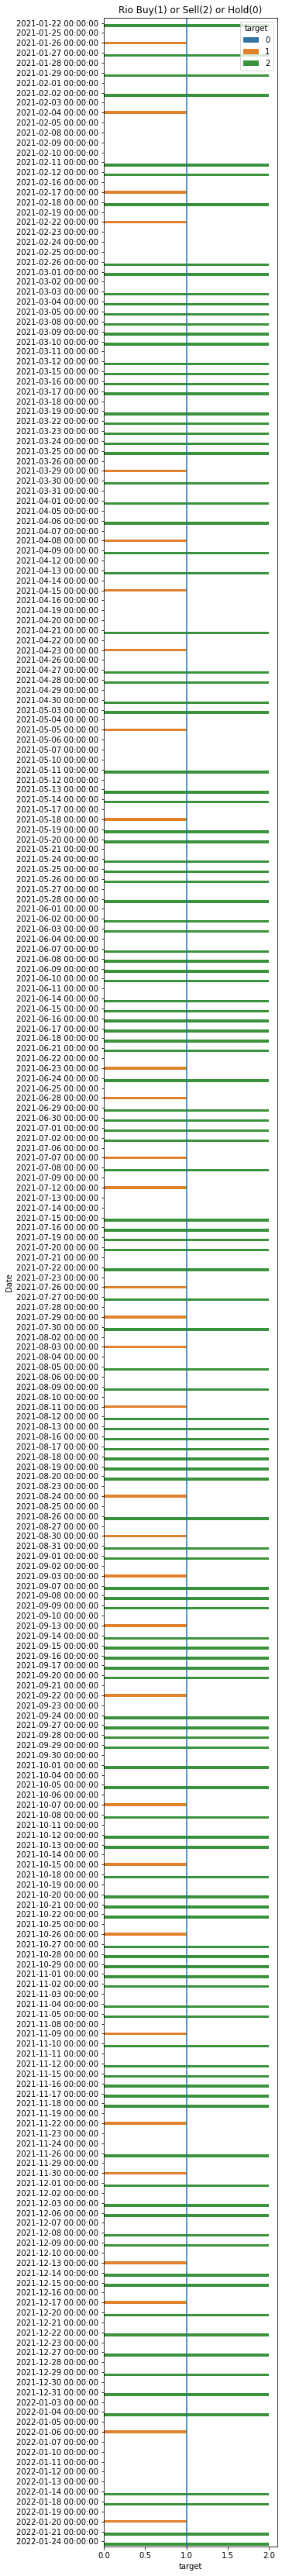

In [18]:
rio_df["buy_count"]=0

def SetOpenPositiveCount(df):
    df["open_pct_positive_count"]=0
    for index in range(len(df)):
    #print(df.iloc[index])
        count=0
        for index2 in (range(index,0,-1)):
            #print(df.iloc[index2]["open_pct_change"])
            if df.iloc[index2]["open_pct_change"]>0:
                count=count+1
                #print("found",count)
            else:
                break
        #print("count",count)
        df.iloc[index, df.columns.get_loc('open_pct_positive_count')]=count
    return df

def SetPctChange(df):
    for index in range(len(df)):
        count=0
        for index2 in (range(index,0,-1)):
            if df.iloc[index2]["open_pct_change"]>0:
                count=count+1
            else:
                break
        df.iloc[index, df.columns.get_loc('buy_count')]=count
        
    df['action']=[ 'Sell' if x['buy_count']==0 else 'Buy' if x['buy_count']==2 else 'Hold' if x['buy_count'] > 2 else 'No Action' for key,x in df.iterrows()]
                
    df["target"]=0
    for index in range(len(df)):
        action=df.iloc[index]["action"]
        if (action=='Buy'):
             df.iloc[index, df.columns.get_loc('target')]=1
        elif (action=='Sell'):
             df.iloc[index, df.columns.get_loc('target')]=2
        
    buy_list=df[df["target"]==1]
    #for index,item in buy_list.iterrows():
    #    print(index,item["Open"],item["open_pct_positive_count"])
    
    today = datetime.datetime.today()
    #filter=df.index.year >=  today.year-1
    #results=df[filter]
    results=df

    return results

rio_df=SetOpenPositiveCount(rio_df)
results=SetPctChange(rio_df)

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('Rio Buy(1) or Sell(2) or Hold(0)')
plt.show()    

Buy 63
Sell 33
Hold 11


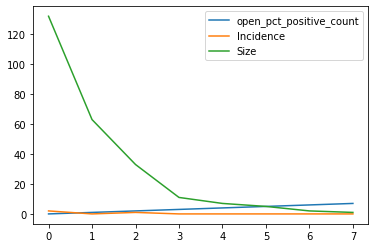

I  want low numbers of buy, high numbers of hold, and low numbers of sell.  Rio is very volatile.  This pattern could change in the near future


In [19]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

# Calculate the predictor insight graph table for the variable gender
pig_table = create_pig_table(rio_df, "target", "open_pct_positive_count")
#print(pig_table)
print("Buy",len(rio_df[rio_df['open_pct_positive_count']==1]))
print("Sell",len(rio_df[rio_df['open_pct_positive_count']==2]))
print("Hold",len(rio_df[rio_df['open_pct_positive_count']==3]))

pig_table.plot()
plt.show()

print("I  want low numbers of buy, high numbers of hold, and low numbers of sell.  Rio is very volatile.  This pattern could change in the near future")

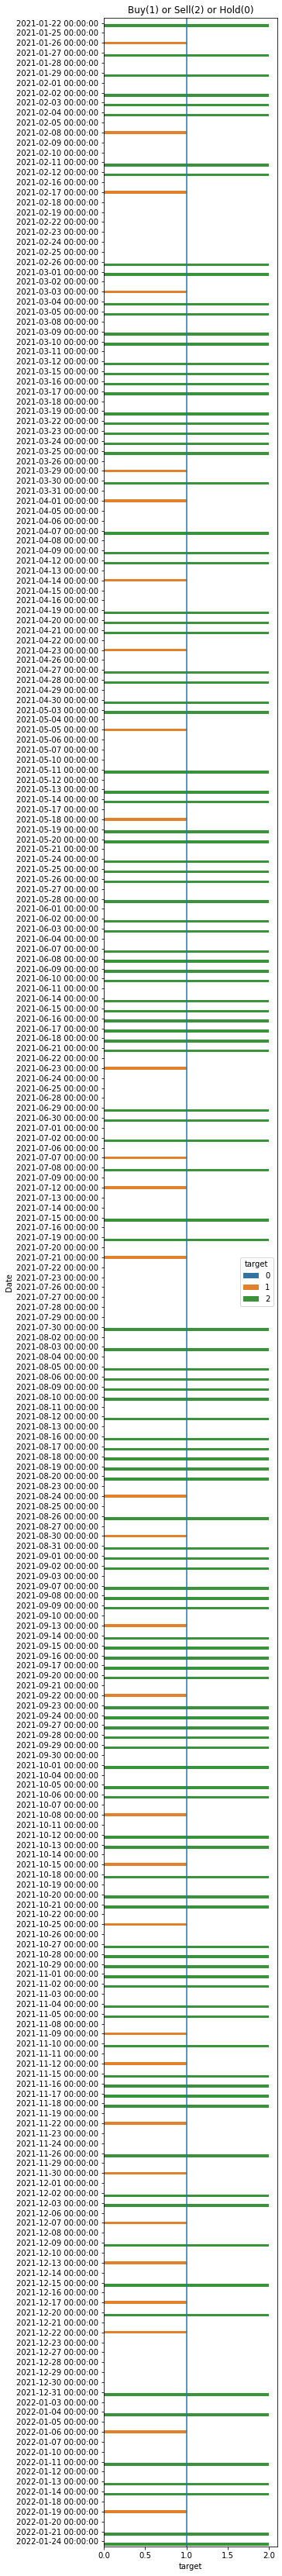

In [20]:
bhp_df["buy_count"]=0
bhp_df=SetOpenPositiveCount(bhp_df)
results=SetPctChange(bhp_df)
    

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('Buy(1) or Sell(2) or Hold(0)')
plt.show()    

Buy 57
Sell 31
Hold 19


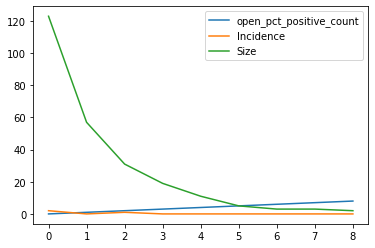

In [21]:
pig_table = create_pig_table(bhp_df, "target", "open_pct_positive_count")
#print(pig_table)
print("Buy",len(bhp_df[bhp_df['open_pct_positive_count']==1]))
print("Sell",len(bhp_df[bhp_df['open_pct_positive_count']==2]))
print("Hold",len(bhp_df[bhp_df['open_pct_positive_count']==3]))

pig_table.plot()
plt.show()

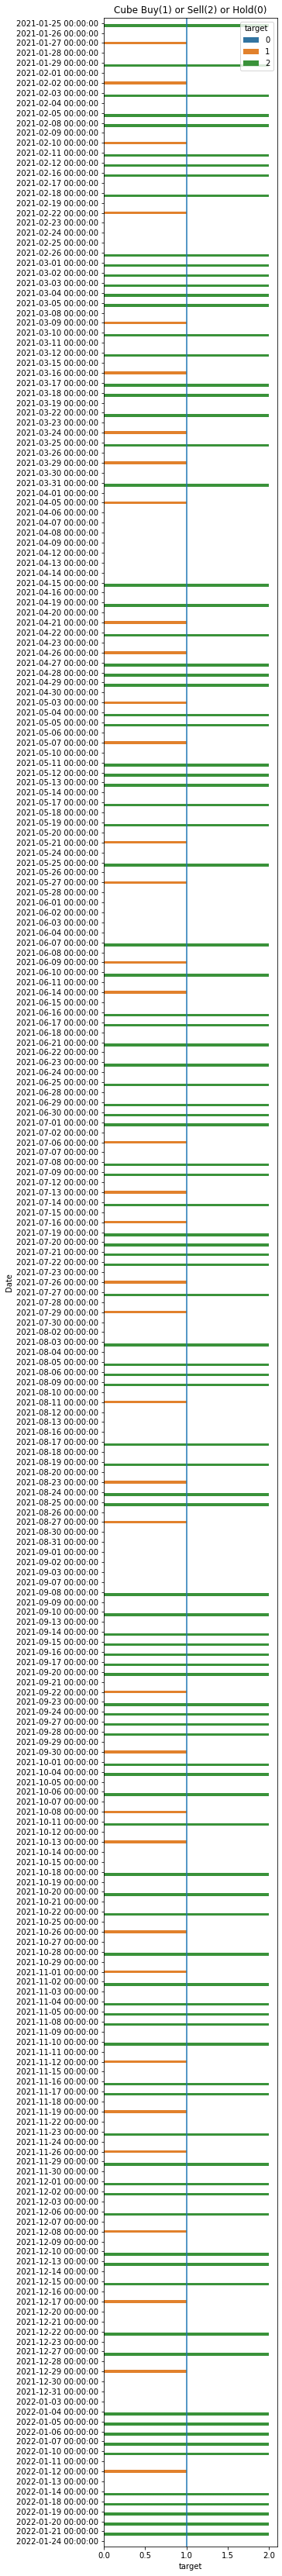

In [22]:
cube_df["buy_count"]=0
cube_df=SetOpenPositiveCount(cube_df)
results=SetPctChange(cube_df)
    

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('Cube Buy(1) or Sell(2) or Hold(0)')
plt.show()  

Buy 63
Sell 38
Hold 20


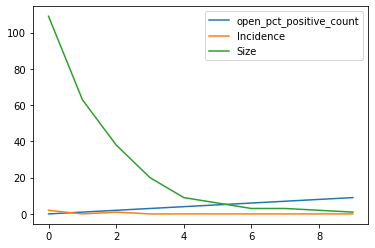

In [23]:
pig_table = create_pig_table(cube_df, "target", "open_pct_positive_count")
#print(pig_table)
print("Buy",len(cube_df[cube_df['open_pct_positive_count']==1]))
print("Sell",len(cube_df[cube_df['open_pct_positive_count']==2]))
print("Hold",len(cube_df[cube_df['open_pct_positive_count']==3]))

pig_table.plot()
plt.show()

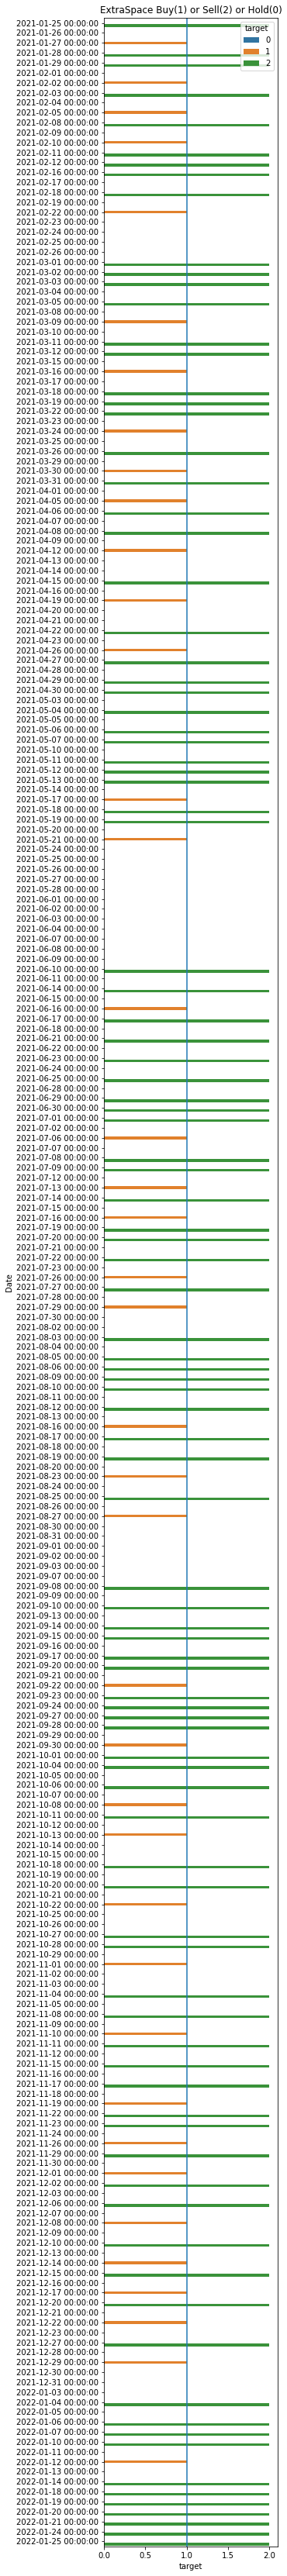

In [24]:
extra_df["buy_count"]=0
extra_df=SetOpenPositiveCount(extra_df)
results=SetPctChange(extra_df)
    

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('ExtraSpace Buy(1) or Sell(2) or Hold(0)')
plt.show() 

Buy 66
Sell 40
Hold 18


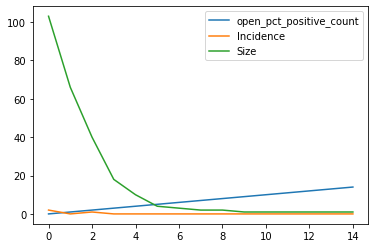

In [26]:
pig_table = create_pig_table(extra_df, "target", "open_pct_positive_count")
#print(pig_table)
print("Buy",len(extra_df[extra_df['open_pct_positive_count']==1]))
print("Sell",len(extra_df[extra_df['open_pct_positive_count']==2]))
print("Hold",len(extra_df[extra_df['open_pct_positive_count']==3]))

pig_table.plot()
plt.show()

Let see if the dividend earns are worth the risk


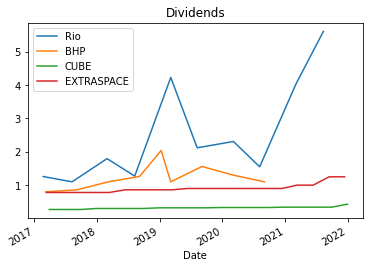

In [31]:
print("Let see if the dividend earns are worth the risk")
rio_dividend_df=pd.read_csv('RIO_Dividend.csv',parse_dates=['Date'],index_col=0)
bhp_dividend_df=pd.read_csv('BHP_Dividend.csv',parse_dates=['Date'],index_col=0)
cube_dividend_df=pd.read_csv('CUBE_Dividend.csv',parse_dates=['Date'],index_col=0)
extra_dividend_df=pd.read_csv('EXR_Dividend.csv',parse_dates=['Date'],index_col=0)

filter=rio_dividend_df.index>'1/1/2017'
rio_dividend_df=rio_dividend_df[filter]
rio_dividend_df['Dividends'].plot(label='Rio')
filter=bhp_dividend_df.index>'1/1/2017'
bhp_dividend_df=bhp_dividend_df[filter]
bhp_dividend_df['Dividends'].plot(label='BHP')
filter=cube_dividend_df.index>'1/1/2017'
cube_dividend_df=cube_dividend_df[filter]
cube_dividend_df['Dividends'].plot(label='CUBE')
filter=extra_dividend_df.index>'1/1/2017'
extra_dividend_df=extra_dividend_df[filter]
extra_dividend_df['Dividends'].plot(label='EXTRASPACE')

plt.legend()
plt.title('Dividends')
plt.show()

C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


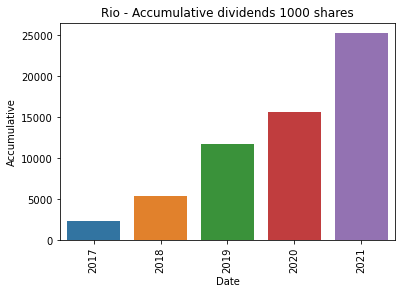

C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


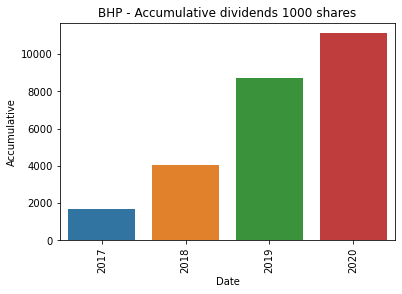

C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


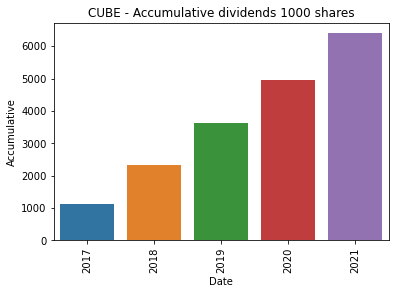

C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


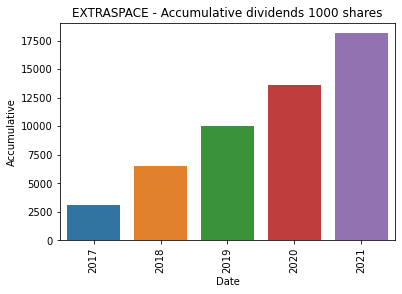

Rio 80230.003 Dividend Earning 5052.8   6.29789332053247
bhp 70379.997 Dividend Earning 2780.0 3.9499859597891143
cube 34970.001000000004 Dividend Earning 1280.0 3.660280135536741
extraspace 115250.0 Dividend Earning 3628.0 3.147939262472885


In [38]:
def AccumulativeEarnings(investment,df,title):
    df['Accum_Earnings']=df['Dividends'].apply(lambda x: x*investment)
    months=df.index.month
    years=df.index.year
    grouped=df.groupby([years,months])['Accum_Earnings'].sum()
    grouped=grouped.unstack()

    fp=df.pivot_table(index=df.index.year,columns=df.index.month,values=['Accum_Earnings'],aggfunc='sum')
    fp['Totals'] = fp.sum(axis='columns')
    fp['Accumulative']=fp['Totals'].cumsum()

    sns.barplot(fp.index,fp['Accumulative'])
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()
    return fp

shares=1000

accum_rio_dividend=AccumulativeEarnings(shares,rio_dividend_df,"Rio - Accumulative dividends 1000 shares")
accum_bhp_dividend=AccumulativeEarnings(shares,bhp_dividend_df,"BHP - Accumulative dividends 1000 shares")
accum_cube_dividend=AccumulativeEarnings(shares,cube_dividend_df,"CUBE - Accumulative dividends 1000 shares")
accum_extra_dividend=AccumulativeEarnings(shares,extra_dividend_df,"EXTRASPACE - Accumulative dividends 1000 shares")

earning=float(accum_rio_dividend['Accumulative'].iloc[-1])/len(accum_rio_dividend)
cost=rio_df['Open'].iloc[0]*shares
percent=float(earning)/float(cost)*100
print("Rio {cost} Avg Dividend Earning {earning}  ratio {percent}".format(cost=cost,earning=earning,percent=percent))

earning=accum_bhp_dividend['Accumulative'].iloc[-1]/len(accum_bhp_dividend)
cost=bhp_df['Open'].iloc[0]*shares
percent=earning/cost*100
print("bhp {cost} Avg Dividend Earning {earning} ratio {percent}".format(cost=cost,earning=earning,percent=percent))

earning=accum_cube_dividend['Accumulative'].iloc[-1]/len(accum_cube_dividend)
cost=cube_df['Open'].iloc[0]*shares
percent=earning/cost*100
print("cube {cost} Avg Dividend Earning {earning} ratio {percent}".format(cost=cost,earning=earning,percent=percent))

earning=accum_extra_dividend['Accumulative'].iloc[-1]/len(accum_extra_dividend)
cost=extra_df['Open'].iloc[0]*shares
percent=earning/cost*100
print("extraspace {cost} Avg Dividend Earning {earning} ratio {percent}".format(cost=cost,earning=earning,percent=percent))



Predicted Dividend pct change


<AxesSubplot:xlabel='Date'>

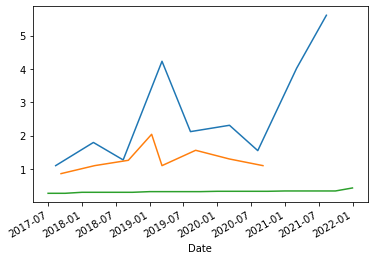

In [34]:
print("Predicted Dividend pct change")

def dividend_by_pct_chg(df):

    first_dividend=df['Dividends'].iloc[0]
    returns=df['Dividends'].pct_change()
    returns_plus_one = returns.add(1)
    accumulative=returns_plus_one.cumprod()
    accumulative=accumulative.mul(first_dividend)
    return accumulative

def plotARMA(df_accumulative,ax,label):
    result=df_accumulative
    result=result.rolling(window=45).mean().dropna()
    mod = sm.tsa.arima.ARIMA(result, order=(2,0,0))
    res = mod.fit()
    # Plot the original series and the forecasted series
    #res.plot_predict(start=0, end=400)
    df_accumulative.plot(ax=ax,label=label)
    res.predict().plot(ax=ax,label=label)

accum_rio_dividend_growth=dividend_by_pct_chg(rio_dividend_df)    
accum_bhp_dividend_growth=dividend_by_pct_chg(bhp_dividend_df)    
accum_cube_dividend_growth=dividend_by_pct_chg(cube_dividend_df)    

accum_rio_dividend_growth.plot()
accum_bhp_dividend_growth.plot()
accum_cube_dividend_growth.plot()

#fig,ax = plt.subplots(figsize=(20,20))    
#plotARMA(accum_rio_dividend_growth,ax,"Rio")
#plotARMA(accum_bhp_dividend_growth,ax,"BHP")
#plt.legend(fontsize=8)
#plt.title("ARMA")
#plt.show()

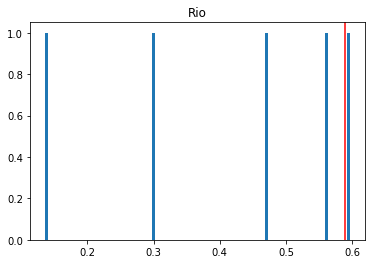

VaR 95 0.5893682237587976 VaR 99 0.5950826985845389


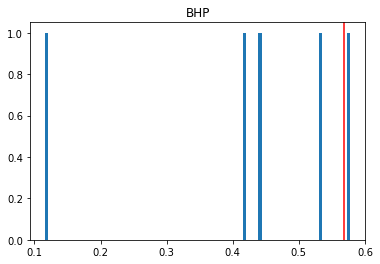

VaR 95 0.5680681215932011 VaR 99 0.5752359411250086


In [35]:
#VaR_95 = norm.ppf(0.95)
#VaR_95 = np.quantile(prices, 0.95)
#print(VaR_95)

array=prices['Rio']
data=preprocessing.normalize([array]).flatten()
#print(data)
VaR_99 = np.quantile(data, 0.99)
VaR_95 = np.quantile(data, 0.95)

plt.hist(data, bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
#plt.hist(prices['BHP'], bins = 100)
plt.title('Rio')
plt.show()

print("VaR 95",VaR_95,"VaR 99",VaR_99)

array=prices['BHP']
data=preprocessing.normalize([array]).flatten()
#print(data)
VaR_99 = np.quantile(data, 0.99)
VaR_95 = np.quantile(data, 0.95)

plt.hist(data, bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
#plt.hist(prices['BHP'], bins = 100)
plt.title('BHP')
plt.show()

print("VaR 95",VaR_95,"VaR 99",VaR_99)

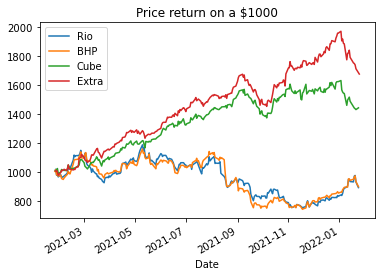

In [37]:
investment=1000

def valuation(df):
    df_returns=df['Open'].pct_change()
    df_returns_plus_one = df_returns.add(1)
    df_cumulative_return = df_returns_plus_one.cumprod()
    return df_cumulative_return.mul(investment)

val=valuation(rio_df)
val.plot(label="Rio")
val=valuation(bhp_df)
val.plot(label="BHP")
val=valuation(cube_df)
val.plot(label="Cube")
val=valuation(extra_df)
val.plot(label="Extra")
plt.legend()
plt.title('Price return on a $1000')
plt.show()